# Aperture photometry

### This Notebook will lead you through exercises to explore signal-to-noise in imaging data. In this notebook, you will:

$\bullet$ learn how to perform aperture photomotry and sky subtraction

$\bullet$ learn how to choose appropriate source aperture and sky aperture sizes

$\bullet$ learn how to calculate errors for your photometry

$\bullet$ look into the difference between source and sky noise

$\bullet$ test your aperture photometry functions on simulated datasets

### If you have time and want to take go further with your analysis:

$\bullet$ test your aperture photometry functions on difficult datasets, such as crowded fields and noisy datasets

### What's next:
after you have completed this notebook:

$\bullet$ move on to the lightcurve simulator exercise

$\bullet$ make sure to make notes on what issues covered here you need to consider when preparing your observations plan

### Additional resources

"Handbook of CCD Astronomy" by Steve B. Howell available in the class.

In [1]:
### Necessary imports fore this notebooks.
# ImageSimulator is a supplemtary set of code used to simulate the test images used 
import ImageSimulator
#Photutils is the model we will use for aperture photometry.
#The documentation is available here: https://photutils.readthedocs.io/en/stable/index.html
from photutils import aperture_photometry
import photutils

## Background - Photometry in Astronomy

For your research project, you will be working with photometry data. This refers to measuring the flux or magnitude of a source in an image. In your project, you will be working with point sources (that means sources that are unresolved at the resolution of the image).

#### Photometry in astronomy is used to:

$\bullet$ measure the flux of a source in a specific band, which can be used to determine the luminosity of a source

$\bullet$ contruct a so-called spectral energy distribution that measures the flux from a source as a function of wavelength or frequency. This can be used to determine intrinsic phyiscal properties of a source, such as its temperature, chemical composition, or in case of a galaxy, the stellar population.

$\bullet$ measure how an object's light evolves with time (often called a lightcurve), which can be used to study transient events such as supernovea, stochastic processes such as accretion onto black holes as well as dynamical systems such as binary stars and exoplanets. The latter example is what you will be working on in your research project. 

#### Signal in astronomical images:

Photometry is measured on images of the sky. Emission detected in such an image may come from:

$\bullet$ the source itself

$\bullet$ other sources in the field

$\bullet$ sky emission, generally uniform across the field

$\bullet$ scatter emission originating from within the instrument

$\bullet$ the bias: a signal added in charged coupled device (CCD) devices to avoid negative counts

#### The signal is affected by:

$\bullet$ differences in transmission through the atmosphere, i.e., only a fraction of flux will arrive on the ground. This is dealt with by measuring the flux relative to a star in the field with known magnitude/flux. You will work on this in the DataReduction section. In your research case, you will be using space-based photometry.

$\bullet$ differences in transmission through the instrument that vary across the field. This is corrected for using so-called flat-fields. Flat fields are images taken of the sky at dawn, these are used to correct for the differences in transmission. You will see an example of this un the DataReduction section. 

#### Spatial resolution in astronomical imaging:

Another important effect is that the image is effectively convoluted by the so-called point-spread function. This means that all point sources are detected as extended sources, here, we treat them as two-d gaussians:

$ PSF(x, y) = \frac{1}{\sigma^2 \sqrt{2\pi}} exp\left[ \frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2}\right] $

where $x_0,y_0$ is the position and $\sigma$ the standard devition. In astronomy, rather than the standard deviation, we often use the so-called full-width at half maximum which is:

$ FWHM = 2 \sqrt{ln 2}\sigma \approx 2.35\sigma$.

#### A side note on units:

Astronomical images can have a range of different units, these can be counts/s. These are related through the gain, which turns counts or electrons per second into photons per second. However, when calculating errors, we are calculating Poisson noise, which is a counting noise error. This error needs to be calculated using the integrated number of photons in the exposure. In this notebook, we will be working with images in units of photons. 

#### Photometry and errors:

To perform aperture photometry, we therefore need to isolate the source emission from other signal and correct for losses in transmission (the latter will be covered in the Data Reduction section).

Additionally, we will need to calculate the error in our measurement. The main source of noise in astronomical data is Poisson or shot noise. The uncertainty $\sigma$ in measuring $N$ photons  is:

$ \sigma = \sqrt{N}$

The number of expected photons scales linearly with time, i.e., by doubling the exposure time, we expected to recieve twice as many photons. Note here that the noise $\sigma$ \textit{increases} with N, however, the property we are interested in is the signal to noise SN, i.e.:

$SN = \frac{N}{\sigma} = \sqrt{N}$

Therefore, since the expected number of photons N $\propto$ exposure time t, the SN increases with the exposure time as \sqrt{t}.

Additionally, due to the fact that the CCD readout adds noise in each pixel, each pixel has an added noise called the read-out noise (RON). This is generally well known for each instrument.

We will need to combine these errors later on, remember these equations for combining errors:

$A = B + C ,\ \sigma_A = \sqrt{\sigma_B^2 + \sigma_C^2}$

$A = B * C \ or A = \frac{B}{C} ,\  \frac{\sigma_A}{A} = \sqrt{\left(\frac{\sigma_B}{B}\right)^2 + \left(\frac{\sigma_C}{C}\right)^2}$

#### There are two general approaches to phomometry:

$\bullet$ Aperture photometry: is very commonly used in astronomy. It in involves integrating the flux from the sources within a (generally circular) aperture. This is the method we will be using here. We will need to consider the size and placement of the aperture and subtraction of background.

$\bullet$ PSF photometry: this involved fitting a model of the PSF to sources. It can be more accurate than aperture photometry, especially in extremely crowded fields where sources overlap. PSF photometry requires a detailed modelling of the PSF across the field. 

This is the summary of background information needed to complete this tutorial.

### Aperture photometry - step by step
Below, you see a simulated image. The colour bar on the right indicates the counts per pixel. Can you locate the source?

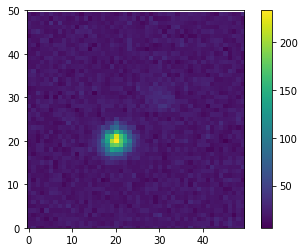

In [2]:
#The line below creates the tutorial image.
myIma = ImageSimulator.tutorial_image()
#You can plot the image like this
myIma.show_ima()

In [4]:
#If you ever need, the data in the image can be accessed like this
test_data = myIma.get_data()
print (test_data)
#This is a numpy array.


[[19 28 14 ... 22 23 24]
 [19 19 21 ... 22 20 21]
 [17 17 25 ... 18 28 21]
 ...
 [24 18 17 ... 15 23 14]
 [19 23 21 ... 21 19 13]
 [21 13 16 ... 15 17 31]]


You can also plot slices through the image in either x or y as folllows.


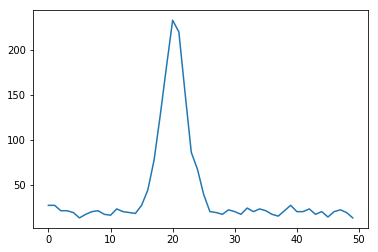

In [5]:
myIma.plot_x(20)

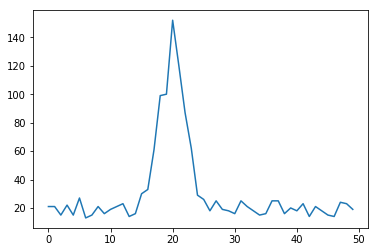

In [6]:
myIma.plot_y(22)

### Your turn: Explore the image

use the slice tool above to explore the image. Where is the source located? What else can you learn using the slice tool?

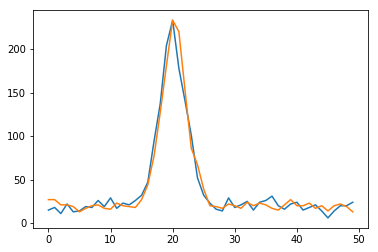

In [7]:
myIma.plot_y(20); myIma.plot_x(20)

## Aperture Photometry - Defining the aperture

Having identified the source visually and using the slice tool, we can now define a circular aperture, this is basically a circular mask that defines the area over which we will sum the flux from the source. We will use photutils.CircularAparture as follows:

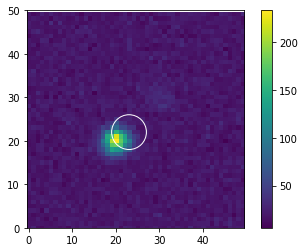

In [8]:
#Defining an aperture:
xpos = 23 #guess for x position
ypos = 22 #guess for y position
rad = 4 #aperture radius
aperture1 = photutils.CircularAperture((xpos, ypos), rad)
#Show the initial image again and overplot the aperture
myIma.show_ima()
aperture1.plot(ec='white')

Try redefining the aperture to match the position.

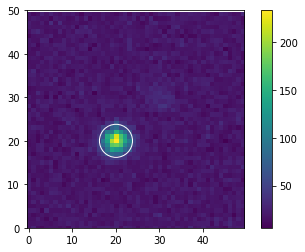

In [9]:
#Defining an aperture:
xpos = 20 #guess for x position
ypos = 20 #guess for y position
rad = 3.8 #aperture radius
aperture1 = photutils.CircularAperture((xpos, ypos), rad)
#Show the initial image again and overplot the aperture
myIma.show_ima()
aperture1.plot(ec='white')

### Aparture Photometry - Calculating fluxes

Having defined the aperture, we can now perform the aperture photometry, the code below shows how we can calculate the flux in the aperture.

In [10]:
#The code below shows how we use the function aperture photometry to apply aperture1 to the image myIma._realima
phot = aperture_photometry(myIma.get_data(), aperture1)
#the result is stored in phot, let's have a look
print(phot)


 id xcenter ycenter    aperture_sum  
      pix     pix                    
--- ------- ------- -----------------
  1    20.0    20.0 5013.773576006283


You can access the results as a dictionary, e.g.:

In [11]:
phot['aperture_sum']

5013.773576006283


In [12]:
#We can access the area covered by the aperture as follows
aperture1.area()

45.36459791783661

### Your turn: make measurements all over the image. Do you notice anything?

In [13]:
# It is pretty consistant

### Aparture Photometry - consider how to best choose the size of the aperture

Try varying the aperture radius and replotting. You can also use the slice plotting you learned above to guide your choioce. What do you think is a good choice for aperture?

In [14]:
#I chose 3.8 as this is approximately the FWHM of the spectra

### Aparture Photometry - Estimating sky levels

The main contamination to the signal will be sky emission. You might have noticed this already. We can estimate sky levels either by creating an annulus around the object or by estimating the sky in different areas of the image. Below, we show how you can use both using the code provided.

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    20.0    20.0 6073.7753233986205
Sky area is :263.89378290154264


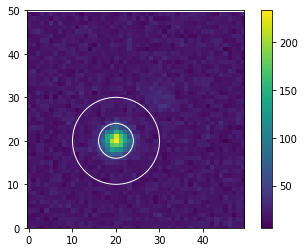

In [16]:
# defining a sky annulus at position 20, 20 with inner radius 4, outer radius 10
ringsky = photutils.CircularAnnulus((20, 20), 4, 10)
# 
sky_annulus = aperture_photometry(myIma.get_data(), ringsky)
print (sky_annulus)
print ('Sky area is :' + str(ringsky.area()))
myIma.show_ima()
ringsky.plot(ec='white')

### Your turn: As with the aperture, consider different sizes for the sky ring.

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    20.0    20.0 3765.4269168566107
Sky area is :150.79644737231007


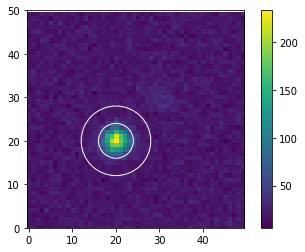

In [17]:
# defining a sky annulus at position 20, 20 with inner radius 4, outer radius 10
ringsky = photutils.CircularAnnulus((20, 20), 4, 8)
# 
sky_annulus = aperture_photometry(myIma.get_data(), ringsky)
print (sky_annulus)
print ('Sky area is :' + str(ringsky.area()))
myIma.show_ima()
ringsky.plot(ec='white')

### Aparture photometry - different ways to measure sky

Above, we have measured the sky using a ring around the source. We could also measure the sky in a circle. 

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    30.0    27.0 1249.6221733176603
Sky area is :50.26548245743669


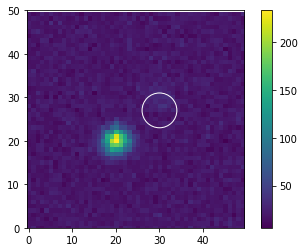

In [19]:
#Defining a sky area 
awaysky = photutils.CircularAperture((30, 27), 4)
#
sky_circle = aperture_photometry(myIma._realima, awaysky)
print (sky_circle)
print ('Sky area is :' + str(awaysky.area()))
myIma.show_ima()
awaysky.plot(ec='white')

### Your turn: Try different sky positions and comment on how the sky should be placed.

### Your turn: Compare the two methods to measure sky levels.

In [24]:
meth1 = sky_circle['aperture_sum']/awaysky.area()
meth2 = (sky_annulus['aperture_sum'])/ringsky.area()

print (meth1)
print (meth2)

   aperture_sum   
------------------
24.860443235092852
  aperture_sum  
----------------
24.9702627778752


### Your turn: Aparture Photometry - Write a function to calculate the flux of a star given the results of the measurements made

You have now measured the flux in the aperture and sky aperture. Write a function to caculate the object flux.

In [25]:
plot_1 = aperture_photometry(myIma.get_data(), aperture1)
plot_2= aperture_photometry(myIma.get_data(), awaysky)

flux = plot_1['aperture_sum']-plot_2['aperture_sum']

print (flux)

   aperture_sum  
-----------------
3764.151402688623


### Your turn: Aparture Photometry - Write a function to calculate the error 

Using the equations given above, write a function to calculate the error in your flux.

In [33]:
import numpy as np
error = np.sqrt(flux) + np.sqrt(meth1) + (np.sqrt(meth1)/ringsky.area())
print (error)
print (((error)/flux)*100)


   aperture_sum  
-----------------
66.37176988166011
   aperture_sum   
------------------
1.7632598368453698


### Aparture photometry: Practice
Below, you can find instructions how to create random images that you can use to test your aperture photometry functions. We will start with a high-SN image with a single star in the field. You can create a random image as follows.

In [34]:
test_me = ImageSimulator.centred_psf_highSN()

NameError: name 'fwhmrange' is not defined

Everytime you rerun the cell above, a different test image is created. You can access the data and show the image as you did before in the tutorial image. This time, you can give a guess for the source position and flux, and the function will then tell you if your estimate is correct. You can plot the x and y slices as was done before.

Here, I am guessing that the source is in the middle of the image, that the source flux is 700, the measurement error in the flux is 50 and the position error is 2.

In [35]:
test_me.guess_psf(x=25,y=25,flux=700, error=50, poserr=2)

NameError: name 'test_me' is not defined

If you are lost, you can get the description of your random image as follows:

In [14]:
test_me.explain_practiceima()

There are 1 Objects in this image
They have the following parameters:
x, y, flux
-----------
26.77, 25.02, 36206.44
-----------
Background level: 4.84
Radius/FWHM: 3.07/7.22
RON: 3.90 added
Shot noise added


## Aparture Photometry - Advanced practice - noisy Images

If you have gotten a good hold of the practice set above, you can try these advanced examples. The first one gives a noisier version of the one above. The guesses and solutions work as above.

In [36]:
test_lowSN = ImageSimulator.centred_psf_lowSN()

NameError: name 'fwhmrange' is not defined

## Aparture Photometry - Advanced practice - Crowded Fields

The next example is more challenging, this is a good chance to make use of plotting to identify where the sources are.

In [37]:
test_crowded = ImageSimulator.crowded_field()

NameError: name 'fwhmrange' is not defined

If you get stuck, you can show the number of objects in the field as follows:

In [17]:
test_crowded.show_objectnumber()

There are 5 PSFs in this field. Good hunting!


You can also reveal the positions.

In [18]:
test_crowded.show_positions()

There are 5 Objects in this image with positions
x, y
-----------
42.06, 13.83
71.56, 66.28
30.45, 6.35
78.81, 83.21
15.26, 16.73


## Summary:

After completing this notebook, you should have:

- written and tested functions for aperture photometry and error estimation. These functions will be used in the next notebook and will need to be included in the final report. Save them in a .py file.
